# Seed setting

In [ ]:
import numpy as np
import torch
import random

def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Preprocess data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/final_data.zip

Archive:  /content/drive/MyDrive/final_data.zip
   creating: final_data/
   creating: final_data/bass/
  inflating: final_data/bass/b_0.xlsx  
  inflating: final_data/bass/b_1.xlsx  
  inflating: final_data/bass/b_2.xlsx  
  inflating: final_data/bass/b_3.xlsx  
   creating: final_data/classical/
  inflating: final_data/classical/c_0.xlsx  
  inflating: final_data/classical/c_1.xlsx  
  inflating: final_data/classical/c_2.xlsx  
  inflating: final_data/classical/c_3.xlsx  
   creating: final_data/jrock/
  inflating: final_data/jrock/j_0.xlsx  
  inflating: final_data/jrock/j_1.xlsx  
  inflating: final_data/jrock/j_2.xlsx  
  inflating: final_data/jrock/j_3.xlsx  
   creating: final_data/wubai/
  inflating: final_data/wubai/w_0.xlsx  
  inflating: final_data/wubai/w_1.xlsx  
  inflating: final_data/wubai/w_2.xlsx  
  inflating: final_data/wubai/w_3.xlsx  


In [ ]:
import pandas as pd
import statistics

def preprocess_data(csv_dir, window_size=100, gt=0):
    #read excel file by pandas
    df=pd.read_excel(csv_dir).values
    #filter value
    mean, std = statistics.mean(df[:,0]), statistics.stdev(df[:,0])
    filter = set()
    for i, num in enumerate(df[:,0]):
        if(num > mean + 3*std or num < mean - 3*std):
            pos = i//(window_size//2)
            filter.add(pos)
            filter.add(max(pos-1, 0))
    filter = sorted(filter)
    #sample data by window size (500ms, 250ms)
    fea = []
    label = []
    for i in range(0, df.shape[0]-window_size, window_size//2):
        if i//(window_size//2) not in filter:
            fea.append(df[i:i+window_size,1:])
            label.append(gt)
    print(f'{len(fea)*(window_size//2)/df.shape[0]*100}% conserve')

    return torch.tensor(np.array((fea))), torch.tensor(np.array((label)))

# Dataset

In [ ]:
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        self.label = y
        if y is not None:
            self.label = y
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


# Model

In [ ]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, input_dim=5, hidden_layers=2, hidden_dim=64, window_size=100, output_dim=2):
        super(Classifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers= hidden_layers,
            batch_first=True,
            dropout=0.42,
            bidirectional=True
        )

        self.l = nn.Sequential(
          nn.LeakyReLU(0.1),
          nn.BatchNorm1d(2*hidden_dim),
          nn.Dropout(0.42),
          nn.Linear(2*hidden_dim, hidden_dim),
          nn.LeakyReLU(0.1),
          nn.BatchNorm1d(hidden_dim),
          nn.Dropout(0.42),
          nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        output, (h,c) = self.lstm(x)
        output = self.l(output[:,window_size//2,:])

        return output

# Hyper-parameters

In [ ]:
# data prarameters
window_size = 100   # the number of data to concat with.
train_ratio = 0.95   # the ratio of data used for training, the rest will be used for validation
music_types = ['bass', 'classical', 'jrock', 'wubai']
num_music = 3
output_dim = len(music_types)

# training parameters
seed = 42            # random seed
batch_size = 512        # batch size
num_epoch = 250         # the number of training epoch
learning_rate = 1e-4      # learning rate
model_path = './model.ckpt'   # the path where the checkpoint will be saved

# model parameters
input_dim = 4            # the input dim of the model, you should not change the value
hidden_layers = 3          # the number of hidden layers
hidden_dim = 256           # the hidden dim

# Dataloader

In [ ]:
from torch.utils.data import DataLoader

#Environment setting
same_seeds(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# preprocess data
X, Y = torch.tensor([0]), torch.tensor([0])
for i, music_type in enumerate(music_types):
    print("music_type: ", music_type)
    for num in range(num_music):
        data_path = f"/content/final_data/{music_type}/{music_type[0]}_{num}.xlsx"
        x, y = preprocess_data(data_path, window_size, i)
        if(X.size()[0] == 1):
            X, Y = x, y
        else:
            X = torch.cat((X, x))
            Y = torch.cat((Y, y))

print("Data size: ", X.size())
print("Label size: ", Y.size())

DEVICE: cuda
music_type:  bass
96.27153752000753% conserve
95.19241412389773% conserve
95.0937950937951% conserve
music_type:  classical
99.81072062754893% conserve
94.8743223262691% conserve
93.99957594176267% conserve
music_type:  jrock
94.52797633719497% conserve
96.21595135749126% conserve
92.97445915635628% conserve
music_type:  wubai
94.97826940521806% conserve
94.73406245186278% conserve
95.3279620623745% conserve
Data size:  torch.Size([11154, 100, 4])
Label size:  torch.Size([11154])


In [ ]:
# get dataset
train_dataset = EEGDataset(X, Y)

# get dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training

In [ ]:
from tqdm import tqdm

# create model, define a loss function, and optimizer
model = Classifier(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    hidden_dim=hidden_dim,
    window_size=window_size,
    output_dim=output_dim
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=3, T_mult=4, eta_min=0)


best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, batch in enumerate((train_loader)):
        features, labels = batch
        features = features.to(device, torch.float32)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)

        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        train_acc += (train_pred.detach() == labels.detach()).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_acc /= len(train_dataset)
    train_loss /= len(train_dataset)
    scheduler.step()

    # save best model
    if best_acc < train_acc:
        best_acc = train_acc
        torch.save(model.state_dict(), model_path)

    print(f'[{epoch+1:03d}/{num_epoch:03d}] Loss: {train_loss:3.5f}, Acc: {train_acc:3.5f}')


[001/250] Loss: 0.00295, Acc: 0.28259
[002/250] Loss: 0.00286, Acc: 0.29998
[003/250] Loss: 0.00284, Acc: 0.29873
[004/250] Loss: 0.00282, Acc: 0.30061
[005/250] Loss: 0.00280, Acc: 0.31191
[006/250] Loss: 0.00277, Acc: 0.31110
[007/250] Loss: 0.00273, Acc: 0.32338
[008/250] Loss: 0.00273, Acc: 0.32652
[009/250] Loss: 0.00272, Acc: 0.32975
[010/250] Loss: 0.00270, Acc: 0.32786
[011/250] Loss: 0.00269, Acc: 0.33791
[012/250] Loss: 0.00268, Acc: 0.33853
[013/250] Loss: 0.00268, Acc: 0.33468
[014/250] Loss: 0.00268, Acc: 0.33719
[015/250] Loss: 0.00267, Acc: 0.34624
[016/250] Loss: 0.00267, Acc: 0.33647
[017/250] Loss: 0.00267, Acc: 0.33925
[018/250] Loss: 0.00264, Acc: 0.35288
[019/250] Loss: 0.00263, Acc: 0.35019
[020/250] Loss: 0.00262, Acc: 0.36193
[021/250] Loss: 0.00259, Acc: 0.36749
[022/250] Loss: 0.00257, Acc: 0.37215
[023/250] Loss: 0.00257, Acc: 0.37852
[024/250] Loss: 0.00255, Acc: 0.37888
[025/250] Loss: 0.00252, Acc: 0.38488
[026/250] Loss: 0.00252, Acc: 0.38990
[027/250] Lo

# Inference

In [ ]:
model = Classifier(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    hidden_dim=hidden_dim,
    window_size=window_size,
    output_dim=output_dim
).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

for i, music_type in enumerate(music_types):
    # preprocess data
    print("music_type: ", music_type)
    data_path = f"/content/final_data/{music_type}/{music_type[0]}_3.xlsx"
    X, Y = preprocess_data(data_path, window_size, i)
    # get dataset
    inference_dataset = EEGDataset(X, Y)
    # get dataloader
    inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)
    # inference
    test_acc = 0.0
    with torch.no_grad():
        li = [0,0,0,0]
        for batch in ((inference_loader)):
            features, labels = batch
            features = features.to(device, torch.float32)
            labels = labels.to(device)
            outputs = model(features)
            _, train_pred = torch.max(outputs, 1)
            test_acc += (train_pred.detach() == labels.detach()).sum().item()
            for pred in train_pred.detach():
                li[pred] += 1
    # calculate prediction
    ans = 0
    M = 0
    for j in range(4):
        if li[j] > M:
            M = li[j]
            ans = j
        li[j] = str(li[j]*100//len(inference_dataset)) + '%'
    # print result
    print(f'[{music_type}] Predict Success: {ans == i}, Sequence Acc: {test_acc/len(inference_dataset):3.5f}')
    print('Distribution:',li)
    print()

music_type:  bass
96.71342550543277% conserve
[bass] Predict Success: True, Sequence Acc: 0.65913
Distribution: ['65%', '21%', '8%', '4%']

music_type:  classical
99.7565548311274% conserve
[classical] Predict Success: True, Sequence Acc: 0.57223
Distribution: ['34%', '57%', '4%', '3%']

music_type:  jrock
94.19790178791312% conserve
[jrock] Predict Success: True, Sequence Acc: 0.42222
Distribution: ['11%', '23%', '42%', '22%']

music_type:  wubai
93.54426182920476% conserve
[wubai] Predict Success: True, Sequence Acc: 0.63924
Distribution: ['3%', '8%', '24%', '63%']



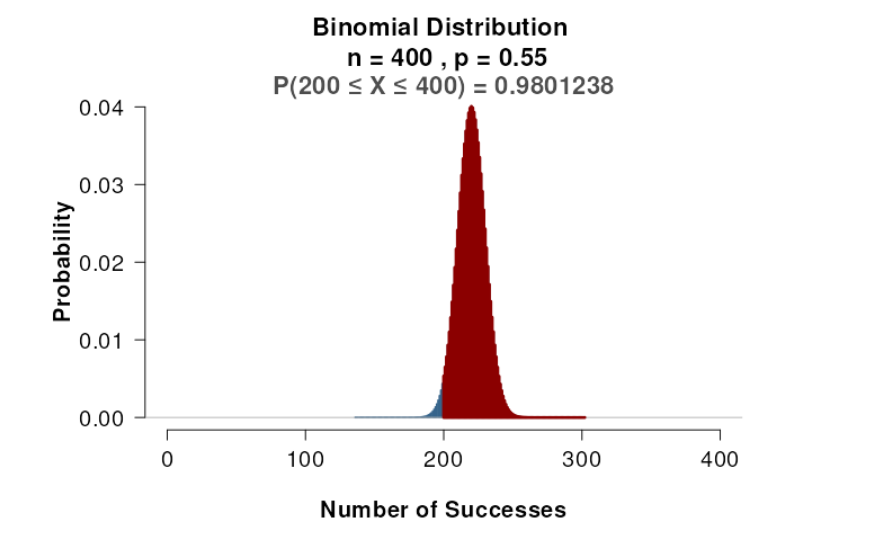